In [1]:
import scniche as sn
import scanpy as sc
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/scniche_v101/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.1.0


In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/50249673)
# adata = sn.datasets.human_dlpfc_visium()
adata = sc.read('DLPFC_donor3.h5ad')
adata

AnnData object with n_obs × n_vars = 14243 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'domain', 'slice'
    uns: 'CN_order'
    obsm: 'X_C2L', 'X_scVI', 'spatial'

In [3]:
celltype_key='domain' # not use, just for `sn.pp.process_multi_slices`
sample_key = 'slice'
use_rep = 'X_scVI'
k_cutoff = 6
lr = 0.01
epochs = 100
batch_num = 2


# prepare multi slices
adata = sn.pp.process_multi_slices(
    adata=adata,
    celltype_key=celltype_key,
    sample_key=sample_key,
    mode='KNN',
    k_cutoff=k_cutoff,
    is_pca=False,
    verbose=False,
    layer_key=use_rep
)

# choose the features of the three views `X_C2L`, `X_data`, and `X_data_nbr` to run scNiche     
choose_views = ['X_C2L', 'X_data', 'X_data_nbr']
adata = sn.pp.prepare_data_batch(adata=adata, verbose=False, batch_num=batch_num, choose_views=choose_views)

# training
model = sn.tr.Runner_batch(adata=adata, device='cuda:0', verbose=False, choose_views=choose_views)
adata = model.fit(lr=0.01, epochs=epochs)

# clustering
target_num = len(set(adata.obs['domain']))
adata = sn.tr.clustering(adata=adata, target_k=target_num)

-------Process 4 slices...


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Applying K-Means Clustering with 7 target cluster numbers...


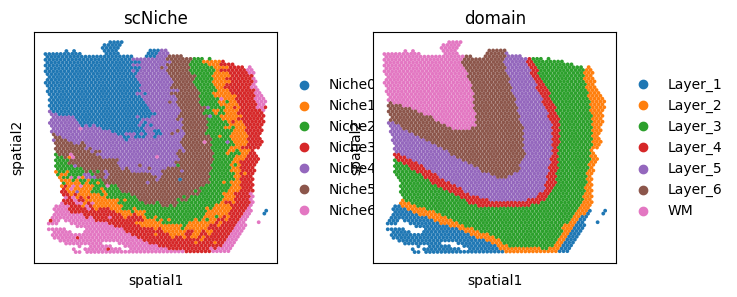

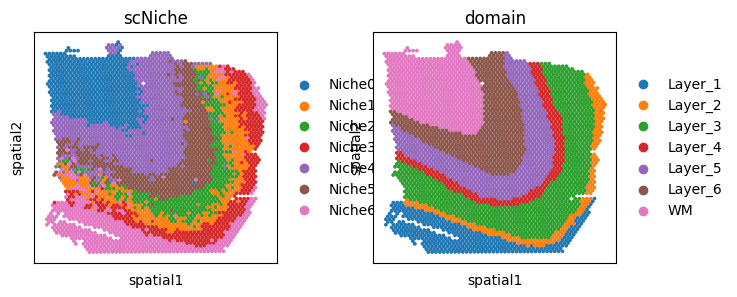

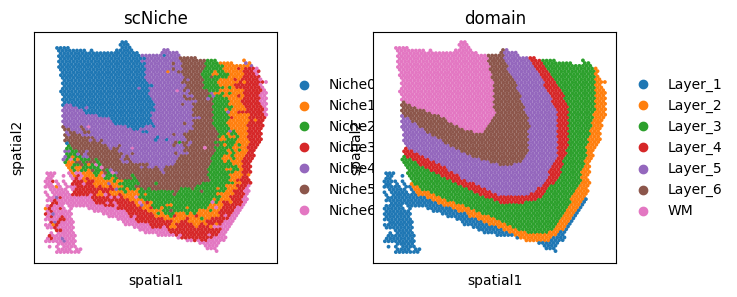

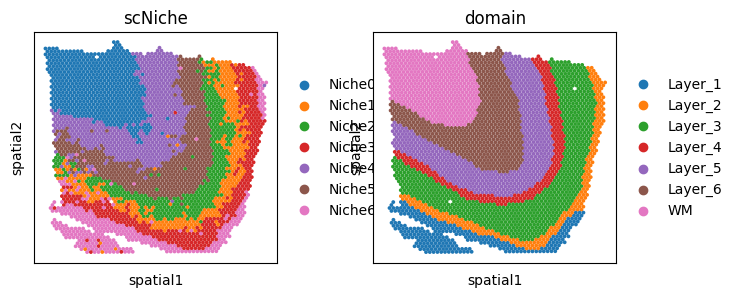

In [4]:
for i in ['151673', '151674', '151675', '151676']:
    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.embedding(adata[adata.obs['slice'] == 'slice' + i], basis="spatial", color=['scNiche', 'domain'],s=30, )

In [5]:
res = adata.obs.copy()
for i in ['151673', '151674', '151675', '151676']:
    res_tmp = res.loc[res['slice'] == 'slice' + i]
    a = res_tmp['domain'].values
    b = res_tmp['scNiche'].values
            
    # ari
    ari_tmp = adjusted_rand_score(a, b)
    
    print(f"slice {i} - ARI: {ari_tmp}")

slice 151673 - ARI: 0.5343164681501748
slice 151674 - ARI: 0.5545313905213357
slice 151675 - ARI: 0.5810943154142099
slice 151676 - ARI: 0.548507847272454
